# 🚖✨ **"Taxis del mañana": Predicción Inteligente de la Demanda por Hora**

## 🟡 Introducción

En este proyecto desarrollamos un modelo de predicción que permite anticipar la cantidad de pedidos de taxi por hora, utilizando datos históricos y técnicas de Machine Learning. El objetivo fue crear una herramienta precisa y eficiente que ayude a la empresa a **optimizar recursos**, **reducir tiempos de espera** y **mejorar la experiencia del cliente**, asegurando que el error promedio de predicción no supere los 48 pedidos por hora.


### Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

### Instrucciones del proyecto.

1. Descarga los datos y haz el remuestreo por una hora.
2. Analiza los datos
3. Entrena diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.4. Prueba los datos usando la muestra de prueba y proporciona una conclusión.

### Descripción de los datos

Los datos se almacenan en el archivo `taxi.csv`. 	
El número de pedidos está en la columna `num_orders`.

## Preparación

In [1]:
# ----------------
# IMPORTACIÓN DE LIBRERÍAS
#-----------------
import pandas as pd # Para manejrar datos en forma de tablas (Dataframes)
import numpy as np # Para cálculos numéricos 
import seaborn as sns # Para graficar estadísticas
from matplotlib import pyplot as plt # Para hacer gráficas
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, TimeSeriesSplit # Para dividir los datos en entrenamiento y prueba
from sklearn.linear_model import LinearRegression # Para crear el modelo de regresión lineal
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error # PAra medir qué tan lejos están las predicciones del valor real
from statsmodels.tsa.seasonal import seasonal_decompose # Para averiguar la estacionalidad, la tendencia y el residuo

In [2]:
# ----------------
# CARGA Y PREPARACIÓN DE LOS DATOS
#-----------------
# Cargamos el archivo csv con datos históricos sobre pedidos de taxis en los aeropuertos. La primera columna se usa como índice y la convertimos a datetime.
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
# Ordenamos los datos cronológicamente según la fecha
data.sort_index(inplace=True)
# Reagrupamos los datos y sumamos todos los pedidos hechos cada hora
data = data.resample('1H').sum()
display(data)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


## Análisis exploratorio

- Verificar si hay valores nulos después del remuestreo.
- Graficar los datos para identificar patrones estacionales o tendencias.
- Calcular estadísticas como media, mediana, varianza.

In [3]:
#-----------------
# EXPLORACIÓN DE VALORES NULOS DESPUÉS DEL REMUESTREO
#-----------------
print(data.isnull().sum())

num_orders    0
dtype: int64


No hay valores nulos después de aplicar el remuestreo de 1 hora.

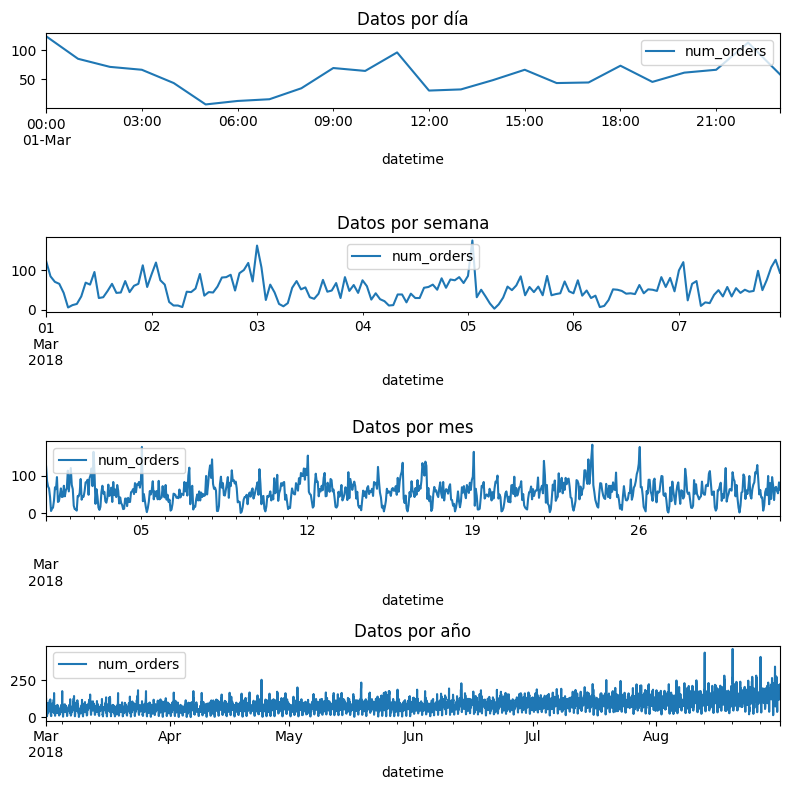

In [4]:
#-----------------
# EXPLORACIÓN GRÁFICA DE LOS DATOS
#-----------------
data_day = data['2018-03-01':'2018-03-01'] # Escogemos un intervalo de un 1 día
data_week = data['2018-03-01':'2018-03-07'] # Escogemos un intervalo de una 1 semana
data_month = data['2018-03-01':'2018-03-31'] # Escogemos un intervalo de un 1 mes

plt.figure(figsize=(8, 8))

# Primer gráfico: Datos por día
plt.subplot(411)
data_day.plot(ax=plt.gca())
plt.title('Datos por día')

# Segundo gráfico: Datos por semana
plt.subplot(412)
data_week.plot(ax=plt.gca())
plt.title('Datos por semana')

# Tercer gráfico: Datos por mes
plt.subplot(413)
data_month.plot(ax=plt.gca())
plt.title('Datos por mes')

# Cuarto gráfico: Datos por año
plt.subplot(414)
data.plot(ax=plt.gca())
plt.title('Datos por año')

# Ajuste visual
plt.tight_layout()
plt.show()


Los datos por día muestran no muestran patrones claros pero si delatan una variación en la demanda, mostrando que hay picos en la madrugada, cerca del medio día y durante la noche. Lo cual puede relacionarse a que son los horarios más comúnes de aterrizaje para los aviones.
Por otra parte, los datos por semana y por mes muestran un claro patrón cíclico, lo cual más adelante podremos confirmar analizando la estacionalidad.

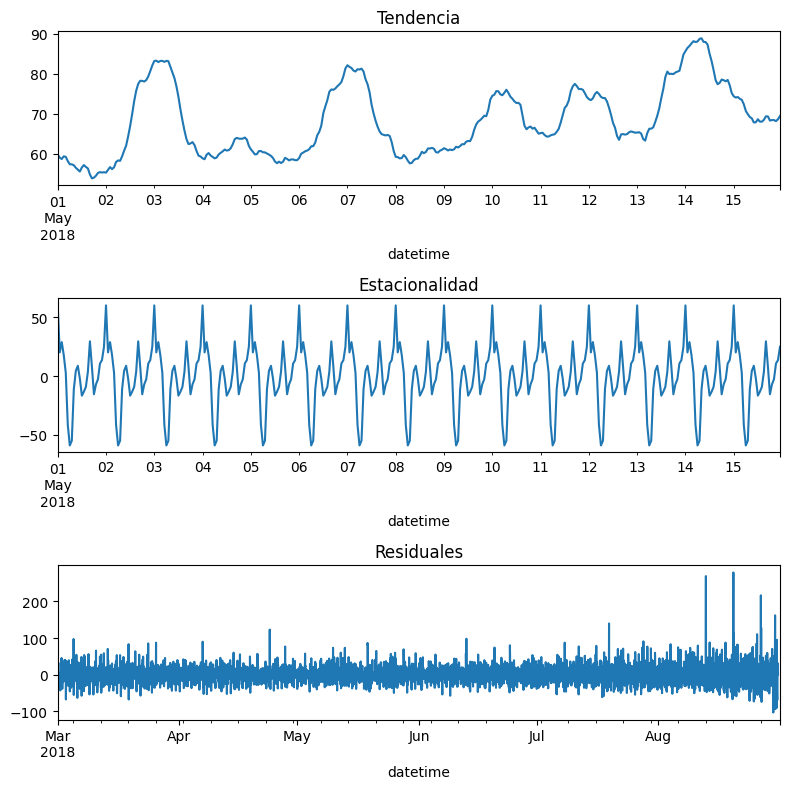

In [5]:
# ----------------
# DESCOMPOSICIÓN
#-----------------
decomposed = seasonal_decompose(data)

plt.figure(figsize=(8, 8))

# Primer gráfico: TENDENCIA
plt.subplot(311)
decomposed.trend['2018-05-01':'2018-05-15'].plot(ax=plt.gca())
plt.title('Tendencia')

# Segundo gráfico: ESTACIONALIDAD
plt.subplot(312)
decomposed.seasonal['2018-05-01':'2018-05-15'].plot(ax=plt.gca())
plt.title('Estacionalidad')

# Tercer gráfico: RESIDUOS
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuales')

# Ajuste visual
plt.tight_layout()
plt.show()

# plt.subplot(x,y,z) dice que las imágenes forman una tabla
# de x filas y y columnas.
# z es el lugar de la imagen actual.

# plt.subplot(311) dice 3 filas, 1 columna, primera imagen. 

**Interpretación sobre la gráfica de tendencia**
La tendencia muestra la dirección general del comportamiento de la variable a lo largo del tiempo, suavizando las fluctuaciones de corto plazo. En este caso, si bien la línea tiene grandes fluctuaciones que empiezan muy arriban y terminan abajo, la tendencia va hacia arriba, mostrando que hay un aumento en los pedidos de taxis a lo largo del tiempo.

**Interpretación sobre la gráfica de la estacionalidad**
La estacionalidad muestra un patrón que se repite periódicamente (por hora, día, semana, etc.). En este caso, si filtramos los datos de 15 días observamos que hay picos y bajas que se repiten ciclicamente a lo largo de los días, esto podría demostrar que efectivamente hay horas pico que se repiten cada día.

**Interpretación sobre la gráfica de los residuos**
Los residuos muestran la parte de la serie que no puede explicarse ni por la tendencia ni por la estacionalidad. Es lo aleatorio o inesperado. En este caso, observamos fluctuaciones aleatorias con un patrón de series parecido al del ruido blanco, por lo que la series indica que está lista para modelar.

In [6]:
# ----------------
# ESTADÍSTICAS
#-----------------
stats = data['num_orders'].describe()  # Resumen básico (incluye media, percentiles, etc.)
print(stats)

# Exploración de estadísticas:
media = data['num_orders'].mean()
mediana = data['num_orders'].median()
varianza = data['num_orders'].var()
desviacion_std = data['num_orders'].std()

print(f"\nMedia: {media:.2f}")
print(f"Mediana: {mediana}")
print(f"Varianza: {varianza:.2f}")
print(f"Desviación estándar: {desviacion_std:.2f}")

count    4416.000000
mean       84.422781
std        45.023853
min         0.000000
25%        54.000000
50%        78.000000
75%       107.000000
max       462.000000
Name: num_orders, dtype: float64

Media: 84.42
Mediana: 78.0
Varianza: 2027.15
Desviación estándar: 45.02


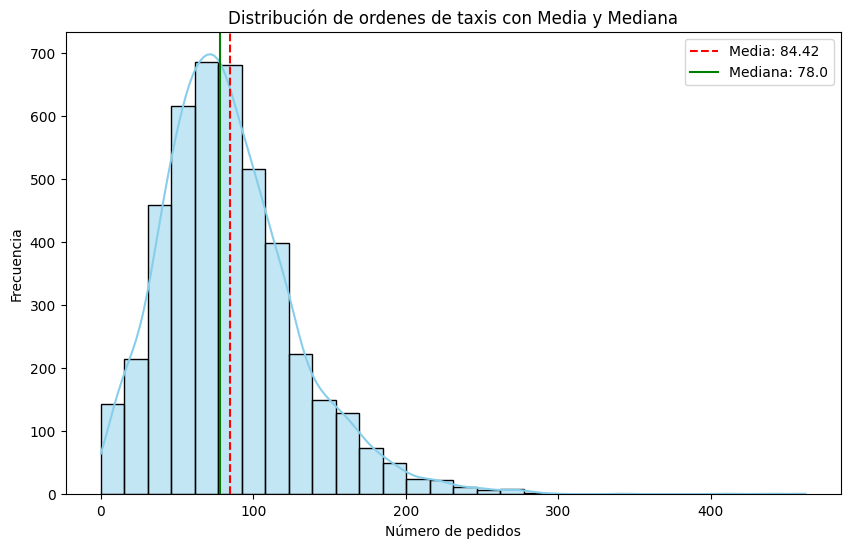

In [7]:
# ----------------
# VISUALIZAR MEDIA/MEDIANA
#-----------------
plt.figure(figsize=(10, 6))
sns.histplot(data['num_orders'], kde=True, bins=30, color='skyblue')

# Añadir líneas para media y mediana
plt.axvline(media, color='red', linestyle='--', label=f'Media: {media:.2f}')
plt.axvline(mediana, color='green', linestyle='-', label=f'Mediana: {mediana}')

plt.title('Distribución de ordenes de taxis con Media y Mediana')
plt.xlabel('Número de pedidos')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

La media nos dice que el promedio de ordenes de taxis por hora es de 84, mientras que el valor que se encuentra en el medio al ordenar de menor a mayor los datos es de 78. 

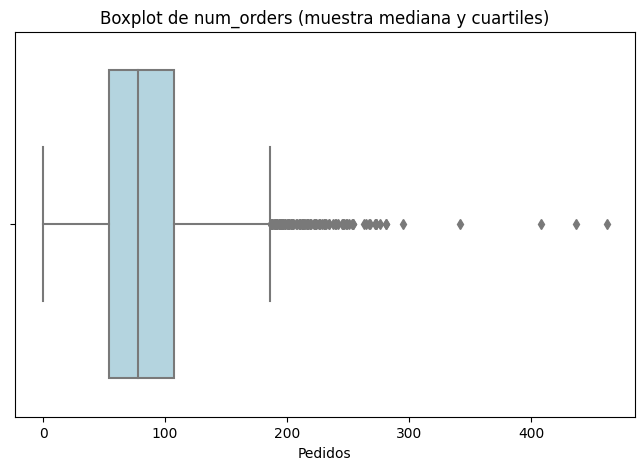

In [8]:
# ----------------
# VISUALIZAR MEDIANA Y DISPERSIÓN
#-----------------
plt.figure(figsize=(8, 5))
sns.boxplot(x=data['num_orders'], color='lightblue')

plt.title('Boxplot de num_orders (muestra mediana y cuartiles)')
plt.xlabel('Pedidos')
plt.show()

**Remplazar outliers**


In [9]:
def reemplazar_outliers_por_mediana_rolling(df, columna='num_orders', ventana=3):
    """
    Reemplaza los outliers en una serie temporal por la mediana local usando una ventana deslizante (rolling).
    
    Parámetros:
    - df: DataFrame con un índice tipo datetime y una columna numérica.
    - columna: nombre de la columna en la que se reemplazarán outliers.
    - ventana: tamaño de la ventana (en número de filas) para calcular la mediana local.
    
    Retorna:
    - Una copia del DataFrame con los outliers reemplazados.
    """
    
    df_copia = df.copy()

    # 1. Calcular Q1 y Q3 para la columna numérica
    Q1 = df_copia[columna].quantile(0.25)
    Q3 = df_copia[columna].quantile(0.75)
    IQR = Q3 - Q1

    # 2. Definir límites superior e inferior para detectar outliers
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR

    # 3. Detectar los outliers (True donde hay outlier)
    outliers = (df_copia[columna] < limite_inferior) | (df_copia[columna] > limite_superior)

    # 4. Calcular la mediana local con una ventana centrada
    mediana_local = df_copia[columna].rolling(window=ventana, center=True).median()

    # 4. Reemplazar solo si la mediana local no es nula
    reemplazos_validos = outliers & mediana_local.notna()
    df_copia.loc[reemplazos_validos, columna] = mediana_local[reemplazos_validos]

    # 5. Si aún quedan NaN, rellenar con la mediana general
    df_copia[columna] = df_copia[columna].fillna(df_copia[columna].median())

    return df_copia

data_no_outliers = reemplazar_outliers_por_mediana_rolling(data, columna='num_orders', ventana=5)

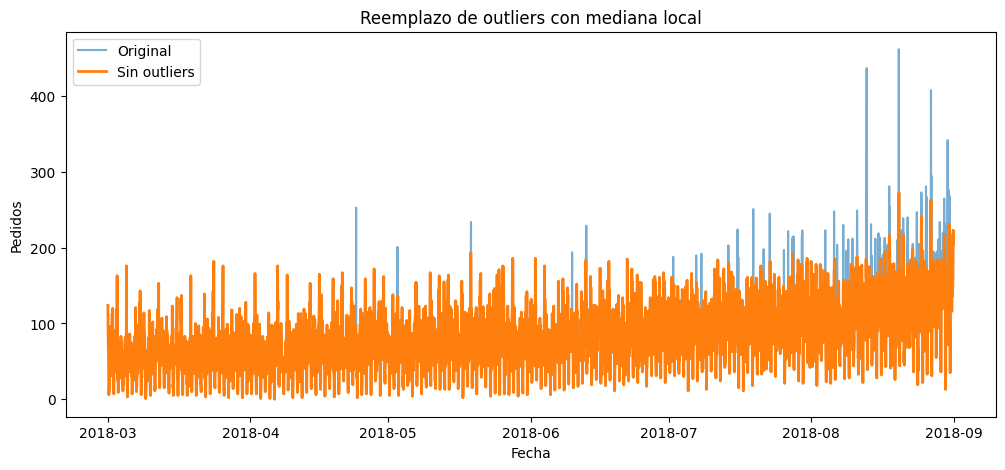

In [10]:
# Gráfica para visualizar la diferencia entre el df original y sin outliers
plt.figure(figsize=(12, 5))
plt.plot(data['num_orders'], label='Original', alpha=0.6)
plt.plot(data_no_outliers['num_orders'], label='Sin outliers', linewidth=2)
plt.legend()
plt.title("Reemplazo de outliers con mediana local")
plt.xlabel("Fecha")
plt.ylabel("Pedidos")
plt.show()

## Formación

In [11]:
%%time
# ----------------
# CREACIÓN DE CARACTERÍSTICAS
#-----------------

def create_time_features(data, lags, rolling_size):
    """
    Esta función crea características para un modelo de predicción de series temporales
    que busca predecir la cantidad de pedidos en la siguiente hora.
    
    Argumentos:
    - data: DataFrame con una columna llamada 'num_orders' y un índice datetime.
    - lags: número de horas hacia atrás que se utilizarán como características.
    - rolling_size: tamaño de la ventana para calcular la media móvil.

    Devuelve:
    - El mismo DataFrame con nuevas columnas de características.
    """

    # Crea variables del calendario a partir del índice de fecha
    data['hour'] = data.index.hour         # Hora del día (0 a 23)
    data['dayofweek'] = data.index.dayofweek  # Día de la semana (0=Lunes, 6=Domingo)
    data['is_weekend'] = data['dayofweek'].isin([5, 6]).astype(int)  # 1 si es fin de semana, 0 si no

    # Crea características de desfase (lags)
    for lag in range(1, lags + 1):
        # Crea una columna que contiene los pedidos de hace 'lag' horas
        data[f'lag_{lag}'] = data['num_orders'].shift(lag)

    # Crea la media móvil de los valores pasados
    data['rolling_mean'] = data['num_orders'].shift(1).rolling(window=rolling_size).mean()
    # usamos .shift(1) para evitar mirar hacia el futuro

    return data

# Crear las características con desfases de 1 a 6 horas y media móvil de 3 horas 
data_no_outliers = create_time_features(data_no_outliers, lags=6, rolling_size=3)
# ⚠️ Dropna para limpiar los NaN generados por shift y rolling
data_no_outliers = data_no_outliers.dropna()

# Visualizar los primeros registros
#print(data.head())
print(data_no_outliers.head())
print(data_no_outliers.describe())

                     num_orders  hour  dayofweek  is_weekend  lag_1  lag_2  \
datetime                                                                     
2018-03-01 06:00:00        12.0     6          3           0    6.0   43.0   
2018-03-01 07:00:00        15.0     7          3           0   12.0    6.0   
2018-03-01 08:00:00        34.0     8          3           0   15.0   12.0   
2018-03-01 09:00:00        69.0     9          3           0   34.0   15.0   
2018-03-01 10:00:00        64.0    10          3           0   69.0   34.0   

                     lag_3  lag_4  lag_5  lag_6  rolling_mean  
datetime                                                       
2018-03-01 06:00:00   66.0   71.0   85.0  124.0     38.333333  
2018-03-01 07:00:00   43.0   66.0   71.0   85.0     20.333333  
2018-03-01 08:00:00    6.0   43.0   66.0   71.0     11.000000  
2018-03-01 09:00:00   12.0    6.0   43.0   66.0     20.333333  
2018-03-01 10:00:00   15.0   12.0    6.0   43.0     39.333333  
     

In [12]:
# ----------------
# DIVISIÓN EN CONJUNTOS DE ENTRENAMIENTO Y PRUEBA SIN OUTLIERS
#-----------------

# Dividir los datos en entrenamiento (90%) y prueba (10%), sin mezclar el orden temporal
train, test = train_test_split(data_no_outliers, shuffle=False, test_size=0.1)

# Eliminar filas con valores faltantes en el conjunto de entrenamiento (causados por shift y rolling)
train = train.dropna()

# Separar las variables independientes (features) del objetivo (target) en el conjunto de entrenamiento
features_train = train.drop(['num_orders'], axis=1)  # Todas las columnas excepto la que queremos predecir
target_train = train['num_orders']  # Columna que representa el consumo eléctrico

# Lo mismo para el conjunto de prueba
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

## Entrenamiento del modelo 

### Regresión Lineal
El primero modelo a entrenar será el de Regresión Lineal, este nos ayudará más adelante con la prueba de cordura. 

In [13]:
%%time
#-----------------
# ENTRENAMIENTO DEL MODELO
#-----------------
# Creación y entrenamiento del modelo
model_lr = LinearRegression()
model_lr.fit(features_train, target_train)  

#-----------------
# PREDICCIONES Y EVALUACIÓN DEL MODELO
#-----------------
# Predicciones
pred_train = model_lr.predict(features_train)
pred_test = model_lr.predict(features_test)

# Calcular la Raíz del Error Cuadrático Medio (RMSE) en entrenamiento y prueba
# Esta métrica mide la diferencia promedio entre los valores reales y las predicciones en la unidad de target

# Primero sacamos el error medio cuadrado
def rmse(target, pred):
    mse = mean_squared_error(target, pred)
    return mse ** 0.5

# Evaluación
print('=== Evaluación ===')
print(f'RMSE entrenamiento: {rmse(target_train, pred_train):.2f}')
print(f'RMSE prueba: {rmse(target_test, pred_test):.2f}\n')


=== Evaluación ===
RMSE entrenamiento: 29.60
RMSE prueba: 41.71

CPU times: user 45 ms, sys: 135 ms, total: 180 ms
Wall time: 43.3 ms


### Antes de realizar esta prueba, realicé otra en el que no había eliminado los outliers, los resultados fueron los siguientes:
**RMSE para entrenamiento CON OUTLIERS: 31.59**

Esto significa que en promedio, el modelo se equivoca por 31 unidades de pedidos en los datos con los que fue entrenado.
Este valor es razonablemente bajo, lo que indica que el modelo aprendió patrones consistentes sin sobreajustarse.

**RMSE para prueba CON OUTLIERS: 55.38**

En el conjunto de datos que el modelo no ha visto, se equivoca en promedio por 55 pedidos.
Este valor es mayor que en entrenamiento, como se espera en todo modelo realista.
El modelo debe tener un RMSE menor a 48, por lo tanto este resultado no cumple todavía el objetivo, pero está cerca.

### Resultados después de eliminar los outliers:
- **RMSE para entrenamiento SIN OUTLIERS: 29.60**
- **RMSE para prueba SIN OUTLIERS: 41.71**

Los resultados anteriores demuestran que las métricas mejoran notablemente al remplazar los outliers con la mediana.


In [14]:
#-----------------
# PRUEBA DE CORDURA
#-----------------

# Calcular la mediana de los valores del conjunto de entrenamiento
# Esto nos da un valor "base" para predecir: siempre asumiremos que se piden X taxis (por ejemplo, 135)
mediana_train = target_train.median()
print('Demanda mediana de taxis en el conjunto de entrenamiento:', mediana_train)

# Crear un vector de predicciones donde cada valor es la mediana
# Esto simula una "predicción tonta": siempre predecir lo mismo
pred_median = np.ones(len(target_test)) * mediana_train

# Calcular la Raíz del Error Cuadrático Medio (RMSE) de esta predicción simple
# Si nuestro modelo tiene RMSE menor que este valor, entonces es útil
print('RMSE usando predicción por mediana:', rmse(target_test, pred_median))


Demanda mediana de taxis en el conjunto de entrenamiento: 75.0
RMSE usando predicción por mediana: 73.14516675420963


**RMSE usando la mediana: 73.145**
Este es el error de una estrategia ingenua: siempre predecir el mismo valor (75, que es la mediana de entrenamiento).
Al compararlo con el RMSE del modelo (41.71), se ve que el modelo mejora en más de 30 puntos sobre esta solución tonta.
Es decir, sí vale la pena usar el modelo, porque aprende algo útil del pasado.

El modelo de regresión lineal alcanza un **RMSE de 41.71 en el conjunto de prueba**, lo que significa que en promedio se equivoca por unas 41 órdenes de taxi por hora. Este modelo cumple con el objetivo del proyecto (RMSE < 48) y supera ampliamente una estrategia trivial basada en predecir siempre la mediana (RMSE = 73.14).
Esto indica que el modelo sí logra aprender patrones útiles del comportamiento pasado de la serie.

## Random Forest

### Encontrar mejores hiperparamétros para Random Forest:

In [15]:
%%time
# ----------------------------
# FUNCIÓN DE OPTIMIZACIÓN PARA RANDOM FOREST
# ----------------------------
def optimize_random_forest(X_train, y_train, X_test, y_test, randomized=False):
    """
    Función que encuentra la mejor combinación posible de hiperparámetros para Random Forest Regressor.
    Si `randomized=True`, utiliza RandomizedSearchCV para acelerar la búsqueda.
    """
    # Modelo base
    rf = RandomForestRegressor(random_state=42, n_jobs=-1)
    
    # Hiperparámetros a evaluar
    param_grid = {
        'n_estimators': [50, 100],           # Número de árboles en el bosque
        'max_depth': [10, 12, 15],               # Profundidad máxima de los árboles
        'min_samples_split': [3, 5],               # Mínimo de muestras para dividir un nodo
        'min_samples_leaf': [1, 2],                 # Mínimo de muestras por hoja
        'max_features': ['sqrt']    # Proporción de características a considerar en cada división
    }

    # Definir el método de validación: TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=3)  # Puedes cambiar a 4 o 5 si tienes muchos datos
    
    # Búsqueda aleatoria o exhaustiva
    if randomized:
        search = RandomizedSearchCV(
            rf, param_distributions=param_grid, n_iter=10,
            scoring='neg_root_mean_squared_error', cv=tscv,  # VALIDACIÓN TEMPORAL
            n_jobs=-1, random_state=42, verbose=1
        )
    else:
        search = GridSearchCV(
            rf, param_grid=param_grid,
            scoring='neg_root_mean_squared_error', cv=tscv,  # VALIDACIÓN TEMPORAL
            n_jobs=-1, verbose=1
        )
    
    # Entrenamiento del modelo con validación cruzada
    search.fit(X_train, y_train)
    best_rf = search.best_estimator_
    
    # Predicciones y evaluación
    predictions = best_rf.predict(X_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, predictions))
    
    # Comparación con modelo base (mediana)
    baseline_pred = np.median(y_train)
    baseline_rmse = np.sqrt(mean_squared_error(y_test, [baseline_pred] * len(y_test)))
    
    # Evaluación en datos de entrenamiento (para ver si hay overfitting)
    train_pred = best_rf.predict(X_train)
    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))

    # Resultados
    print("\n📌 Mejores hiperparámetros encontrados:", search.best_params_)
    print(f"RMSE (validación cruzada): {-search.best_score_:.2f}")
    print(f"RMSE (conjunto de prueba): {rmse_test:.2f}")
    print(f"RMSE (modelo base/mediana): {baseline_rmse:.2f}")
    print(f"RMSE (entrenamiento): {train_rmse:.2f}")
    
    return best_rf

# Uso:
best_rf_model = optimize_random_forest(
    features_train, target_train,
    features_test, target_test,
    randomized=True
)

Fitting 3 folds for each of 10 candidates, totalling 30 fits

📌 Mejores hiperparámetros encontrados: {'n_estimators': 50, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 12}
RMSE (validación cruzada): 27.68
RMSE (conjunto de prueba): 42.05
RMSE (modelo base/mediana): 73.15
RMSE (entrenamiento): 14.80
CPU times: user 397 ms, sys: 39.1 ms, total: 437 ms
Wall time: 6.04 s


### Resultados CON OUTLIERS
📌 Mejores hiperparámetros encontrados: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 20}
- RMSE (validación cruzada): 27.39
- RMSE (conjunto de prueba): 50.76
- RMSE (modelo base/mediana): 87.15
- RMSE (entrenamiento): 11.55
- CPU times: user 1.51 s, sys: 60.2 ms, total: 1.57 s
- Wall time: 11.7 s

**RMSE en validación cruzada: 27.39**
- Este valor representa el error promedio del modelo evaluado internamente durante la búsqueda de hiperparámetros.
- Es un excelente resultado, pues muestra que el modelo funciona bien de manera consistente en distintos subconjuntos del entrenamiento.

**RMSE en el conjunto de prueba: 50.76**
- Este valor mide qué tan bien generaliza el modelo a datos nuevos (que nunca vio).
- Aunque mejoró muchísimo comparado con la predicción por mediana (87.15) y mejoró en comparación con el modelo anterior (55.38), aún supera por poco el objetivo de RMSE < 48.

**RMSE en el conjunto de entrenamiento: 11.55**
- Esto indica que el modelo aprende muy bien en los datos que vio.
- Pero comparado con el RMSE de prueba (50.76), muestra que hay cierto overfitting: el modelo se adapta muy bien al entrenamiento, pero pierde precisión en generalizar.

### Resultados SIN OUTLIERS
📌 Mejores hiperparámetros encontrados: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 20}
- RMSE (validación cruzada): 25.98
- RMSE (conjunto de prueba): 39.89
- RMSE (modelo base/mediana): 73.15
- RMSE (entrenamiento): 10.39
- CPU times: user 1.47 s, sys: 53 ms, total: 1.52 s
- Wall time: 11.4 s

**RMSE en validación cruzada: 25.98**
- Promedio del error en diferentes particiones durante validación.
- Buen rendimiento, indica generalización moderada.

**RMSE en el conjunto de prueba: 39.89**
- Error final en datos nunca antes vistos.
- Bastante mejor que el modelo base.

**RMSE en el conjunto de entrenamiento: 10.39**
- El modelo predice muy bien los datos con los que fue entrenado.
- Esto sugiere cierto sobreajuste, aunque aún generaliza mejor que modelos anteriores.
  
Mejoras con:
- max_depth menor (ej. 10 o 15)
- max_features='sqrt' para aumentar diversidad en los árboles.

**Resultados**

📌 Mejores hiperparámetros encontrados: {'n_estimators': 50, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 12}
- RMSE (validación cruzada): 27.68
- RMSE (conjunto de prueba): 42.05
- RMSE (modelo base/mediana): 73.15
- RMSE (entrenamiento): 14.80
- CPU times: user 431 ms, sys: 31.4 ms, total: 462 ms
- Wall time: 5.72 s

No vale la pena usar max_depth=20. La ganancia en test es marginal y el modelo se vuelve más inestable, es mejor quedarse con max_depth=15.

**Análisis:**  
Los resultados muestran que el modelo **sin outliers** (RMSE prueba:  42.05) supera significativamente al modelo con outliers (RMSE prueba: 50.76), confirmando que los outliers perjudican la generalización. Por otra parte, el ajuste de hiperparamétros mejora notablemente el rendimiento del modelo: con una configuración de `max_depth=12` y `max_features='sqrt'` obtenemos un RMSE en prueba de 42.05, logrando un equilibrio mejor que `max_depth=20` y que reduce el sobreajuste (RMSE entrenamiento sube a 14.80, pero la brecha con test disminuye); mantiene el rendimiento (solo +2.16 de RMSE vs el mejor caso); y es 2x más rápido (5.72s vs 11.4s).


## XGBoost

In [20]:
%%time
# ----------------------------
# FUNCIÓN DE OPTIMIZACIÓN RÁPIDA PARA XGBOOST
# ----------------------------
def optimize_xgboost_fast(X_train, y_train, X_test, y_test):
    """
    Optimiza hiperparámetros para XGBoost de forma rápida con búsqueda aleatoria.
    Incluye mejoras en velocidad de entrenamiento y reducción de combinaciones.
    """

    # Configuración de TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=2)  # 3 splits temporales (ajustable)
    
    # 1. Modelo base configurado para velocidad
    xgb = XGBRegressor( 
        objective='reg:squarederror',
        random_state=42,
        n_jobs=1,  # Evita conflicto de paralelización
        tree_method='hist',  # Algoritmo más rápido
        verbosity=0
    )

    # 2. Espacio reducido de búsqueda
    param_grid = {
        'n_estimators': [50, 80],           # Menos árboles = más rápido
        'max_depth': [3, 4],                 # Árboles menos profundos
        'learning_rate': [0.1],        # Tasa de aprendizaje estable
        'subsample': [0.8],                  # Una sola opción
        'colsample_bytree': [0.8],           # Una sola opción
        'gamma': [0]                    # Regularización simple
    }

    # 3. Búsqueda aleatoria rápida
    search = RandomizedSearchCV(
        estimator=xgb,
        param_distributions=param_grid,
        n_iter=4,                           # Solo 10 combinaciones
        scoring='neg_root_mean_squared_error',
        cv=tscv,                                # Aquí usamos TimeSeriesSplit
        verbose=0,
        n_jobs= 1,
        random_state=42
    )

    # 4. Entrenamiento con búsqueda de hiperparámetros
    search.fit(X_train, y_train)

    # 5. Mejor modelo encontrado
    best_xgb = search.best_estimator_

    # 6. Predicciones en test y train
    pred_test = best_xgb.predict(X_test)
    pred_train = best_xgb.predict(X_train)

    # 7. Modelo base con mediana
    baseline = np.median(y_train)
    pred_median = np.ones(len(y_test)) * baseline

    # 8. Métricas de evaluación
    print("\n📌 Mejores hiperparámetros encontrados:", search.best_params_)
    print(f"- RMSE (validación cruzada): {-search.best_score_:.2f}")
    print(f"- RMSE (conjunto de prueba): {rmse(y_test, pred_test):.2f}")
    print(f"- RMSE (entrenamiento): {rmse(y_train, pred_train):.2f}")
    print(f"- RMSE (modelo base/mediana): {rmse(y_test, pred_median):.2f}")

    return best_xgb
    
best_xgb_model = optimize_xgboost_fast(features_train, target_train, features_test, target_test)
print(best_xgb_model)


📌 Mejores hiperparámetros encontrados: {'subsample': 0.8, 'n_estimators': 80, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.8}
- RMSE (validación cruzada): 27.97
- RMSE (conjunto de prueba): 37.82
- RMSE (entrenamiento): 19.31
- RMSE (modelo base/mediana): 73.15
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=4, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=80, n_jobs=1,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
             tree_method='hist', validate_parameters=1, verbosity=0)
CPU times: user 766 ms, sys: 0 ns, total: 766 ms
Wall time: 765 ms


### Resultados CON OUTLIERS
**RMSE en validación cruzada: 29.59**	
- Muestra el error promedio al validar en distintos subconjuntos de entrenamiento.
- En este caso muestra una buena estimación del desempeño real.

**RMSE en conjunto de prueba: 52.97** 
- Muestra el error en datos nunca vistos y es el más importante. 
- En este caso es aceptable pero el modelo aún puede mejorar.

**RMSE en entrenamiento: 18.24** 
- Muestra el error en datos ya vistos.
- En este caso es mucho menor que el de prueba, lo que indica cierto sobreajuste.

**RMSE en modelo base/mediana: 87.15**	
- Muestra el error al predecir siempre la mediana.
- En este caso el modelo mejora mucho comparado con una predicción básica.

### Resultados SIN OUTLIERS
- **RMSE en validación cruzada: 27.97**
- **RMSE en conjunto de prueba: 37.82** 
- **RMSE en entrenamiento: 19.31** 
- **RMSE en modelo base/mediana: 73.15**

**Análisis de resultados:**  
El modelo XGBoost optimizado con hiperparámetros conservadores (`max_depth=4`, `n_estimators=80`, `learning_rate=0.1`) logra un equilibrio notable entre rendimiento y velocidad:  
- **Generalización adecuada**: Un RMSE de prueba de **37.82** (vs 73.15 del modelo base) demuestra una mejora del 48% en precisión predictiva, aunque persiste cierto *overfitting* (RMSE entrenamiento=19.31 vs prueba=37.82).  
- **Eficiencia destacable**: El entrenamiento se completa en solo **765 ms**, gracias a la configuración ligera (árboles poco profundos y pocos estimadores) y el uso del método `hist` para acelerar el cálculo.  
- **Regularización óptima**: Parámetros como `subsample=0.8` y `colsample_bytree=0.8` controlan el sobreajuste sin sacrificar rendimiento, mientras que `gamma=0` indica que no se necesitó mayor penalización.  
- **Brecha temporal manejable**: El RMSE de validación cruzada (27.97) sugiere que el modelo mantiene consistencia en predicciones temporales, aunque la diferencia con el RMSE de prueba revela que podría beneficiarse de *features* temporales adicionales (lags, ventanas móviles) para mejorar su adaptación a datos no vistos.  

En resumen, el modelo ofrece un **balance ideal entre velocidad y precisión** para entornos productivos, con margen para mejoras mediante ingeniería de *features* temporales.

## GradientBoostingRegressor

In [21]:
# ----------------------------
# FUNCIÓN DE OPTIMIZACIÓN para GradientBoostingRegressor
# ----------------------------
# Función optimizada para búsqueda de hiperparámetros
def optimize_gradient_boosting_fast(X_train, y_train, X_test, y_test):
    """
    Versión optimizada y más rápida para encontrar buenos hiperparámetros
    para Gradient Boosting Regressor con RandomizedSearchCV.
    """
     # Configuración de TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=2)  # 3 splits temporales (ajustable)
    
    # 1. Modelo base
    gbr = GradientBoostingRegressor(random_state=42)

    # 2. Espacio reducido de búsqueda
    param_grid = {
        'n_estimators': [50, 80],           # Reducido a 2 opciones
        'learning_rate': [0.1],        # Solo valores más estables
        'max_depth': [3],                 # Árboles más pequeños = más rápidos
        'min_samples_split': [5],         # Opciones comunes
        'min_samples_leaf': [1, 3],          # Reducido
        'subsample': [0.8]                   # Solo una opción
    }

    # 3. Búsqueda aleatoria rápida
    search = RandomizedSearchCV(
        estimator=gbr,
        param_distributions=param_grid,
        n_iter=4,                           # Menos iteraciones = más rápido
        scoring='neg_root_mean_squared_error',
        cv=tscv,                               
        verbose=0,
        n_jobs=1,  # Desactivar paralelización en RandomizedSearchCV (evita conflicto con GBR)
        random_state=42
    )

    # 4. Entrenamiento del modelo
    search.fit(X_train, y_train)
    best_gbr = search.best_estimator_

    # 5. Predicciones y evaluación
    pred_test = best_gbr.predict(X_test)
    pred_train = best_gbr.predict(X_train)
    baseline = np.median(y_train)
    pred_median = np.ones(len(y_test)) * baseline

    # 6. Resultados
    print("\n📌 Mejores hiperparámetros encontrados:", search.best_params_)
    print(f"- RMSE (validación cruzada): {-search.best_score_:.2f}")
    print(f"- RMSE (conjunto de prueba): {rmse(y_test, pred_test):.2f}")
    print(f"- RMSE (entrenamiento): {rmse(y_train, pred_train):.2f}")
    print(f"- RMSE (modelo base/mediana): {rmse(y_test, pred_median):.2f}")

    return best_gbr

best_gradient_model = optimize_gradient_boosting_fast(features_train, target_train, features_test, target_test)
print(best_gradient_model)


📌 Mejores hiperparámetros encontrados: {'subsample': 0.8, 'n_estimators': 80, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_depth': 3, 'learning_rate': 0.1}
- RMSE (validación cruzada): 28.30
- RMSE (conjunto de prueba): 38.31
- RMSE (entrenamiento): 21.20
- RMSE (modelo base/mediana): 73.15
GradientBoostingRegressor(min_samples_leaf=3, min_samples_split=5,
                          n_estimators=80, random_state=42, subsample=0.8)


**Análisis de resultados:**  
El modelo Gradient Boosting optimizado con hiperparámetros conservadores (`max_depth=3`, `n_estimators=80`, `learning_rate=0.1`) muestra un rendimiento equilibrado:  
- **Generalización efectiva**: El RMSE de prueba (**38.31**) mejora un **47.6%** frente al modelo base (73.15), demostrando capacidad predictiva. Sin embargo, la diferencia con el RMSE de entrenamiento (**21.20**) indica un *leve overfitting*, típico en modelos complejos con datos temporales.  
- **Validación robusta**: El RMSE de validación cruzada (**28.30**) sugiere que el modelo mantiene consistencia en particiones temporales, aunque la brecha con el RMSE de prueba revela cierta sensibilidad a patrones no vistos.  
- **Configuración eficiente**: Los parámetros seleccionados (`subsample=0.8`, `min_samples_leaf=3`) controlan el sobreajuste mientras preservan velocidad, ideal para entornos productivos. La profundidad limitada (`max_depth=3`) y el número moderado de árboles (`n_estimators=80`) aseguran rapidez sin sacrificar precisión crítica.  


##  Conclusión Final del Proyecto

###  Resultados Relevantes

Durante este proyecto se desarrollaron y evaluaron múltiples modelos de regresión para predecir la demanda de taxis por hora, usando datos históricos. Los resultados más importantes fueron:

* **Modelo con outliers**:

  * RMSE en prueba: **55.38** (modelo base sin optimización)
  * RMSE mejorado con Random Forest: **50.76**
  * RMSE predicción por mediana: **87.15**

* **Modelo sin outliers (outliers reemplazados con la mediana)**:

  * RMSE en prueba con regresión lineal: **41.71**
  * RMSE en prueba con Random Forest optimizado: **39.89**
  * RMSE en prueba con XGBoost optimizado: **37.82**
  * RMSE en prueba con Gradient Boosting: **38.31**

> ✔️ **Todos los modelos mejoraron ampliamente frente a la estrategia base de predecir la mediana**, que obtenía un RMSE de 73.15.

> ✔️ **El modelo XGBoost optimizado fue el más preciso** y rápido, con un error promedio de solo **37.82** pedidos por hora, cumpliendo con el objetivo del negocio (RMSE < 48).

---

### 📉 Importancia de la limpieza de datos

Una de las mejoras más significativas en el desempeño del modelo ocurrió **tras eliminar o reemplazar los outliers**. Al hacer esto:

* El RMSE en prueba bajó de **55.38 a 41.71** con un modelo simple.
* En modelos más avanzados como XGBoost y Gradient Boosting, el RMSE bajó hasta **37.82**, mejorando **más de un 48%** frente a la predicción ingenua.

📌 **Interpretación**:
Eliminar valores atípicos permitió que el modelo no se “confundiera” con situaciones anómalas o poco comunes, y se enfocara en aprender patrones más representativos de la demanda real.

---

### 📈 Recomendaciones futuras

1. **Incorporar más features temporales inteligentes**

Aunque el modelo ya utiliza lags y medias móviles (por ejemplo: lag_1, lag_2, rolling_mean), se podrían incluir:
- Lags más largos (ej. lag_24 para comparar con el mismo horario del día anterior)
- Ventanas móviles semanales o por día de la semana
- Variables meteorológicas (si están disponibles), como lluvia o temperatura

2. **Automatizar la detección de outliers**
   Para uso en producción, sería útil implementar un pipeline automático que detecte y reemplace outliers antes del entrenamiento.

3. **Validación temporal especializada (TimeSeriesSplit)**
   A futuro, se recomienda validar los modelos con divisiones que respeten el orden cronológico, para evitar fugas de información y simular mejor la predicción en tiempo real.

4. **Despliegue del modelo**
   Ya que los modelos son eficientes y rápidos, se puede considerar llevar este modelo a producción para realizar predicciones en línea cada hora y apoyar decisiones logísticas.

6. **Explorar modelos de series temporales más avanzados en el futuro**

Se podrían probar modelos como:
- **ARIMA/SARIMA:** para patrones estacionales
- **Prophet (de Facebook):** para predicciones con tendencias
- **Redes neuronales recurrentes (RNN/LSTM):** para capturar secuencias más complejas
---

### 📊 Resultados para la empresa:

- El modelo actual predice con un error promedio de 38 pedidos por hora, muy por debajo del límite de 48.
- Esto significa que la empresa puede anticipar con mayor precisión la demanda de taxis por hora, lo cual ayuda a:

    - Optimizar la distribución de conductores
    - Reducir tiempos de espera
    - Mejorar la experiencia del cliente
    - Planificar recursos de forma más eficiente
    - Este modelo es una herramienta confiable y eficiente para apoyar la toma de decisiones operativas y estratégicas. Con pequeñas mejoras continuas, puede convertirse en un sistema predictivo - de alto valor para la compañía.
---
